

# **1.   Configuration**



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras.utils import np_utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
opportunities = pd.read_csv('/content/gdrive/My Drive/HKUST_Fintech_Course_Data/opportunities_table_for_prediction_v3.csv', engine='python')
opportunities = opportunities.iloc[:,2:]

In [ ]:
#reverse engineer the country mapping table
#opportunities[['name_entity', 'Region']].groupby(['name_entity', 'Region']).size().to_csv('/content/gdrive/My Drive/HKUST_Fintech_Course_Data/countries_mapping.csv')

# **2. Data Profiling**

##### **2.1 Data Profiling - Overall Data**

In [ ]:
##Quick overview of the data
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381484 entries, 0 to 381483
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   opportunity_id                  381484 non-null  int64  
 1   created_at                      381484 non-null  object 
 2   applications_close_date         90789 non-null   object 
 3   openings                        381484 non-null  int64  
 4   earliest_start_date             381484 non-null  object 
 5   latest_end_date                 381458 non-null  object 
 6   duration_min                    381484 non-null  int64  
 7   programme_id                    381484 non-null  object 
 8   name_region                     381484 non-null  object 
 9   name_entity                     381484 non-null  object 
 10  favourites_count                381484 non-null  int64  
 11  opportunity_applications_count  381484 non-null  int64  
 12  status          

In [ ]:
##Evaluate the columns which should be numeric but object
columns_object = opportunities.select_dtypes(include='object').columns

#show the unique values of each column
for i in columns_object:
    print(i,' has unique values of ',opportunities[i].astype('str').unique())

created_at  has unique values of  ['2014-11-05' '2014-11-17' '2015-01-05' ... '2017-12-29' '2017-12-30'
 '2017-12-31']
applications_close_date  has unique values of  ['2015-03-30' '2015-06-15' '2015-01-01' ... '2019-02-27' '2018-10-24'
 '2019-07-01']
earliest_start_date  has unique values of  ['2015-02-01' '2014-12-15' '2014-11-17' ... '2018-03-21' '2019-03-25'
 '2019-07-16']
latest_end_date  has unique values of  ['2015-07-31' '2015-06-15' '2015-11-17' ... '2020-05-28' '2020-05-30'
 '2019-09-05']
programme_id  has unique values of  ['Global Talent' 'Global Volunteer' 'Global Entrepreneur']
name_region  has unique values of  ['Americas' 'Asia Pacific' 'AIESEC INTERNATIONAL' 'Europe'
 'Middle East and Africa']
name_entity  has unique values of  ['Peru' 'India' 'Asia Pacific' 'Costa Rica' 'Brazil' 'Paraguay' 'Poland'
 'Greece' 'Middle East and Africa' 'Egypt' 'Argentina' 'Romania' 'Germany'
 'Chile' 'Mexico' 'Colombia' 'Russia' 'Malta' 'Singapore' 'Italy'
 'Thailand' 'Panama' 'South Kore

In [ ]:
##Quick overview of the actual data
opportunities.head()

,opportunity_id,created_at,applications_close_date,openings,earliest_start_date,latest_end_date,duration_min,programme_id,name_region,name_entity,favourites_count,opportunity_applications_count,status,month_created,year_created,background_p_count,skill_r_count,skill_p_count,language_r_count,language_p_count,new_status,realized,created_month,open_window,flexibility,start_month,Region,Arts,Business,Engineering,Humanity,Other,Politics,Science
0,290499,2014-11-05,2015-03-30,1,2015-02-01,2015-07-31,20,Global Talent,Americas,Peru,0,3,open,2014-11-01,2014-01-01,0,4,3,2,0,realized,1,11,145.0,180.0,2,South America,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,290500,2014-11-05,2015-06-15,1,2014-12-15,2015-06-15,20,Global Talent,Asia Pacific,India,0,4,open,2014-11-01,2014-01-01,1,7,1,1,0,realized,1,11,222.0,182.0,12,South-central Asia,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,290502,2014-11-17,2015-01-01,1,2014-11-17,2015-11-17,50,Global Talent,AIESEC INTERNATIONAL,Asia Pacific,0,4,open,2014-11-01,2014-01-01,0,5,3,1,0,NaN,0,11,45.0,365.0,11,Asia Pacific,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,290503,2014-11-05,2014-12-31,1,2015-01-01,2015-07-31,24,Global Talent,AIESEC INTERNATIONAL,Asia Pacific,0,19,open,2014-11-01,2014-01-01,1,2,1,1,0,realized,1,11,56.0,211.0,1,Asia Pacific,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,290505,2015-01-05,2016-01-01,1,2015-05-12,2016-01-27,6,Global Volunteer,Americas,Costa Rica,9,7,open,2015-01-01,2015-01-01,1,3,1,1,3,realized,1,1,361.0,260.0,5,Central America,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
##Quick overiew of the basic statistics of the data
opportunities.realized = opportunities.realized.astype('int')
opportunities.describe()

,opportunity_id,openings,duration_min,favourites_count,opportunity_applications_count,background_p_count,skill_r_count,skill_p_count,language_r_count,language_p_count,realized,created_month,open_window,flexibility,start_month,Arts,Business,Engineering,Humanity,Other,Politics,Science
count,381484.000000,381484.000000,381484.00000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000,381484.000000
mean,520723.429090,1.890344,12.30947,1.628191,7.238526,1.150242,2.410437,2.962947,0.911865,0.715760,0.403372,6.499581,155.430255,157.004313,6.275133,0.126123,0.182296,0.045462,0.007964,0.056023,0.000849,0.004276
std,155806.937544,3.372766,13.71868,8.354226,32.190732,0.822548,2.325688,2.503923,0.672084,1.101138,0.490575,3.319524,61.628123,154.677986,3.314781,0.323906,0.378767,0.204816,0.083058,0.217634,0.026095,0.059930
min,290499.000000,0.000000,-6.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,397761.750000,1.000000,6.00000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,159.396836,49.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,497087.500000,1.000000,6.00000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000,6.000000,159.396836,78.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,597490.250000,1.000000,12.00000,0.000000,1.000000,2.000000,4.000000,4.000000,1.000000,1.000000,1.000000,9.000000,159.396836,212.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,893776.000000,29.000000,78.00000,531.000000,2281.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,12.000000,625.000000,1095.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### **2.1 Data Profiling - Target Variable**

In [ ]:
##The distribution of the target variable
Realized_opp = opportunities.groupby('realized')['opportunity_id'].nunique().loc[True]
Not_realized_opp = opportunities.groupby('realized')['opportunity_id'].nunique().loc[False]

print('The realization rate is ', round(Realized_opp/(Realized_opp+Not_realized_opp),3))
print('The baseline using majority classifer is ', round(Not_realized_opp/(Realized_opp+Not_realized_opp),3))

The realization rate is  0.403
The baseline using majority classifer is  0.597


In [ ]:
##Correlation against the target variable
opportunities.corr()['realized'].sort_values(ascending = False)

realized                          1.000000
opportunity_applications_count    0.086392
favourites_count                  0.077387
Arts                              0.051803
open_window                       0.041259
Other                             0.024518
background_p_count                0.015446
language_p_count                  0.015106
Humanity                          0.009168
language_r_count                  0.008230
Politics                          0.007128
Science                           0.002954
skill_r_count                    -0.011309
skill_p_count                    -0.014728
Business                         -0.023705
start_month                      -0.025533
created_month                    -0.031847
openings                         -0.033402
Engineering                      -0.054813
duration_min                     -0.061490
opportunity_id                   -0.078686
flexibility                      -0.123820
Name: realized, dtype: float64

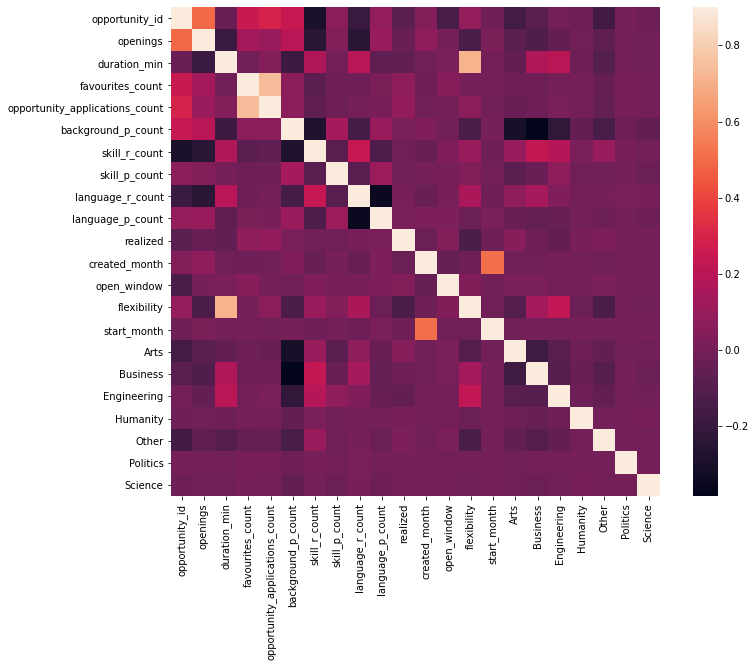

In [ ]:
##Correlation map to see how features are correlated with the target variable

corrmat = opportunities.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

programme_id         realized
Global Entrepreneur  0             5705
                     1             1915
Global Talent        0            90885
                     1            41413
Global Volunteer     0           131014
                     1           110552
Name: opportunity_id, dtype: int64
Region                     realized
Asia Pacific               0            3538
                           1            1664
Australia and New Zealand  0             410
                           1             317
Caribbean                  0             132
                           1              55
Central America            0            3775
                           1            5240
Central Asia               0             510
                           1             376
Eastern Africa             0            7152
                           1            5295
Eastern Asia               0           19055
                           1           11583
Eastern Europe             0 

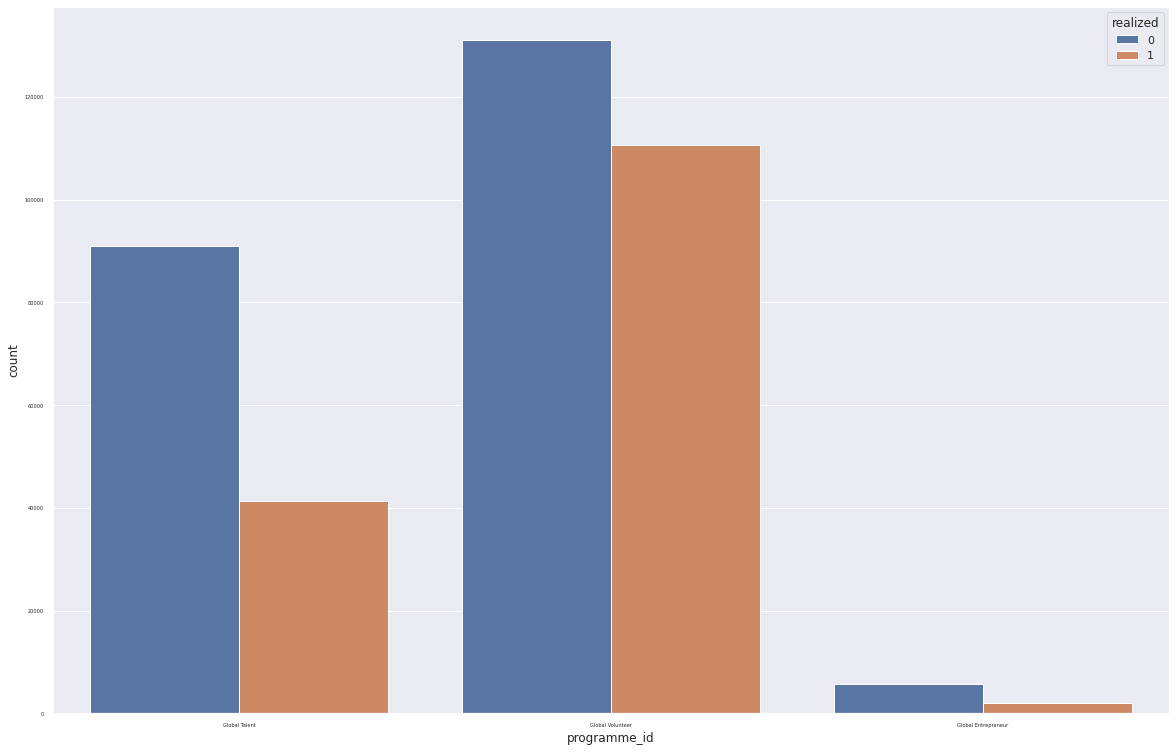

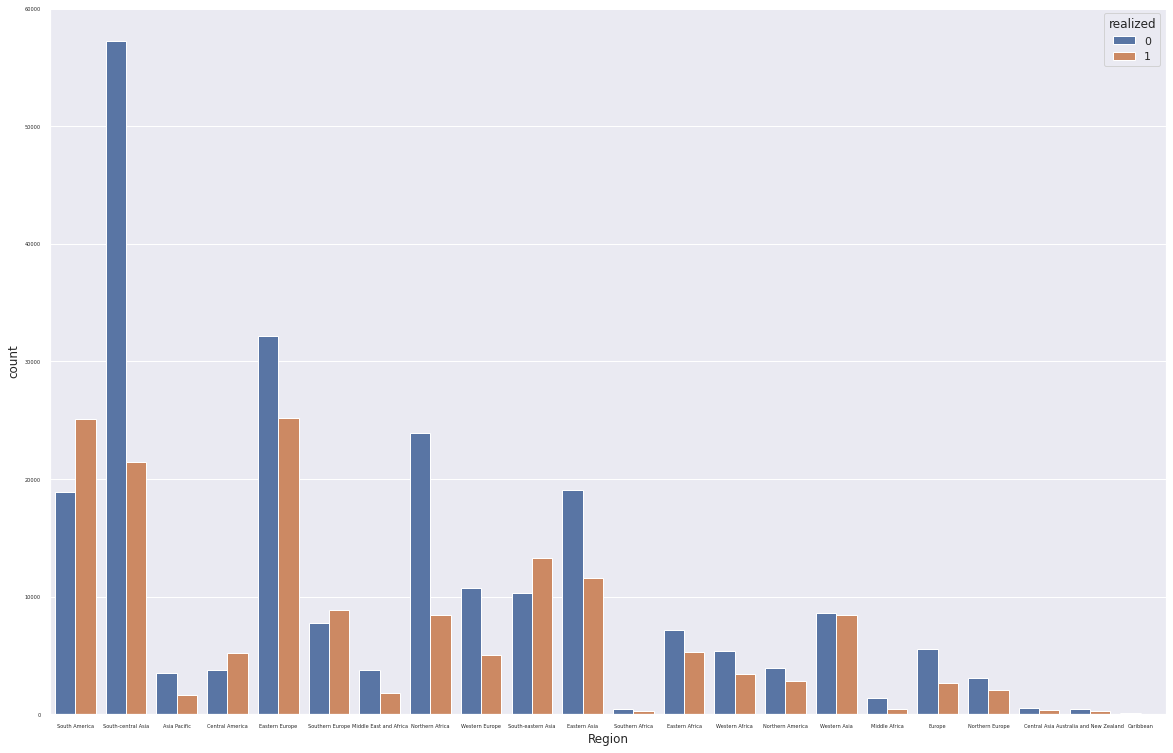

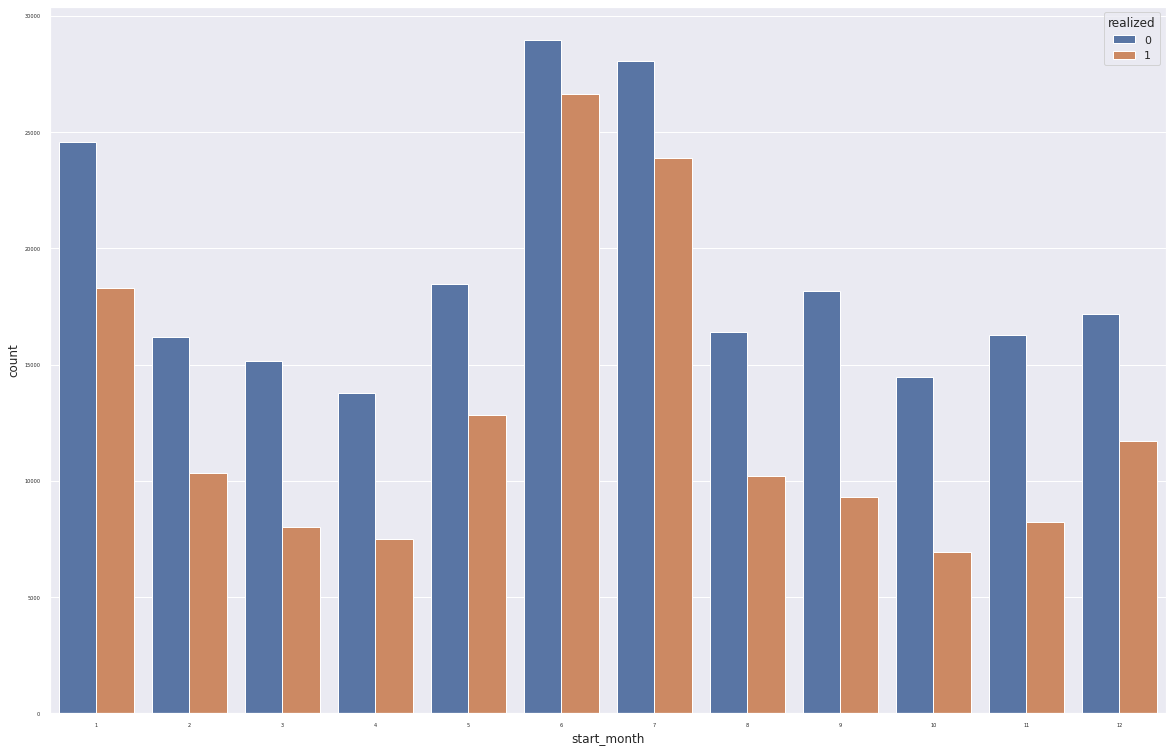

In [ ]:
#plot chosen categorical variables against the target variable
barchart_variable = ['programme_id', 'Region', 'start_month']
target_variable = 'realized'

#fig, axes = plt.subplots(nrows=np.ceil(len(boxplot_variable)/4), ncols=4)
for index, i in enumerate(barchart_variable, start = 0):
    print(opportunities.groupby([i,target_variable]).count()['opportunity_id'])
    sns.set()
    fig, ax = plt.subplots(figsize = (20,13))
    ax = sns.countplot(x = i, hue = target_variable, data = opportunities)
    ax.tick_params(labelsize=5)
    #opportunities.boxplot(column = [target_variable], by = [i], ax = axes[])

**Observation**

For programme_id, we observe that global volunteer program has the highest realization rate.

For Region, South America, Central America, Southern Europe and South-eastern Asia have higher realized opportunities than not realized opportunities. This indicates the flavor of the participants.

For start_month, opportunities that started at Dec, Jan, June and July have a higher realization rate. This might be due to the winter and summer holidays.

# **3. Data Processing for ML**

In [ ]:
## select out the important features
opportunities_cleaned = opportunities[['realized', 'start_month', 'programme_id', 'name_entity', 'duration_min', 'Arts', 'Business', 'Engineering', 'Humanity', 'Other', 'Politics', 'Science', 'background_p_count', 'skill_r_count', 'skill_p_count', 'language_r_count', 'language_p_count','open_window','flexibility','openings']]

**Rationale of variables selection**

**t0 data**

The first rationale would be using variables at t0. As we would like provide the output score for marketing team to prioritise the opportunities, we would like to select the variables which would only appear upon opportunity creation. Therefore, "favourites_count" and "opportunity_applications_count" will be excluded.

**Time Variable**

As we would like to predict based on the inner attributes of the opportunity, we will exclude the time related variables. Yet, start_month will be maintained as this shows the seasonality of favorites and will be treated as a categorical variable.

In [ ]:
## one-hot encoding
opportunities_cleaned_one_hot = pd.get_dummies(opportunities_cleaned, columns=['programme_id', 'name_entity', 'start_month'])

## normalize the dataset
dataset = opportunities_cleaned_one_hot.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## split X and y
X = dataset[:,1:]
y = dataset[:,0]

## split to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

## change data type
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

## evaluate the shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X.shape

(343335, 160) (343335,)
(38149, 160) (38149,)


(381484, 160)

In [ ]:
## evaluate the correlation against target variable after one-hot encoding
opportunities_cleaned_one_hot.corr()["realized"].sort_values(ascending=False)

realized                         1.000000
programme_id_Global Volunteer    0.145371
name_entity_Brazil               0.078199
name_entity_Argentina            0.071525
start_month_6                    0.063918
                                   ...   
duration_min                    -0.061490
name_entity_Egypt               -0.108029
flexibility                     -0.123820
programme_id_Global Talent      -0.134187
name_entity_India               -0.145362
Name: realized, Length: 161, dtype: float64

# **4. Modelling and Evaluation**

4 models will be used for the prediction. (Multi-layer perceptron, Naive Bayes, Decision Tree and Logistics Regression)

**4.1 Multi-layer Perceptron (Deep Learning)**

**4.1.1 Initial Model Building**

In [ ]:
## Model Building

num_pixels = X.shape[1]
def base_model(init_mode='uniform', dropout = 0.0):

  model = Sequential()
  model.add(Dense(200, input_dim=num_pixels,kernel_initializer=init_mode, activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  model.add(Dense(100, kernel_initializer=init_mode,activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  model.add(Dense(50, kernel_initializer=init_mode,activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  #model.add(Dense(50, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

**4.1.2 Hyper-parameter Search**

Batch size, epochs, initialization mode and dropout rate are chosen for hyper-parameter search.

In [7]:
## Hyper-parameter Search

model = KerasClassifier(build_fn=base_model, verbose=0)

batch_size = [32, 64, 128, 256]
epochs = [10, 20]
init_mode = ['uniform', 'normal', 'glorot_normal', 'glorot_uniform']
dropout = [0.1, 0.3, 0.5]
param_grid = dict(batch_size=batch_size, epochs=epochs, init_mode=init_mode, dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train[:50000,:], y_train[:50000])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.673340 using {'batch_size': 256, 'dropout': 0.5, 'epochs': 20, 'init_mode': 'glorot_normal'}
0.666560 (0.002215) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'init_mode': 'uniform'}
0.667540 (0.001592) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'init_mode': 'normal'}
0.668700 (0.004090) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'init_mode': 'glorot_normal'}
0.668340 (0.001994) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'init_mode': 'glorot_uniform'}
0.666700 (0.003552) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 20, 'init_mode': 'uniform'}
0.667400 (0.003141) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 20, 'init_mode': 'normal'}
0.666320 (0.001406) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 20, 'init_mode': 'glorot_normal'}
0.666260 (0.003833) with: {'batch_size': 32, 'dropout': 0.1, 'epochs': 20, 'init_mode': 'glorot_uniform'}
0.668160 (0.005619) with: {'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'init_mo

**4.1.3 Model Building (Optimized Hyper-parameter)**

In [26]:
## Model Building
print("Best: 0.673340 using {'batch_size': 256, 'dropout': 0.5, 'epochs': 20, 'init_mode': 'glorot_normal'}")

num_pixels = X.shape[1]
def create_model(init_mode='uniform', dropout = 0.0):

  model = Sequential()
  model.add(Dense(200, input_dim=num_pixels,kernel_initializer=init_mode, activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  model.add(Dense(100, kernel_initializer=init_mode,activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  model.add(Dense(50, kernel_initializer=init_mode,activation='relu',kernel_regularizer=regularizers.l2(0.00005)))
  model.add(Dropout(dropout))
  #model.add(Dense(50, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

## Model Architecture

dnn_n = create_model(init_mode='glorot_normal', dropout = 0.5)
dnn_n.summary()

Best: 0.673340 using {'batch_size': 256, 'dropout': 0.5, 'epochs': 20, 'init_mode': 'glorot_normal'}
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 200)               32200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
__________________

**4.1.4 K-fold Cross Validation**

Peform K-fold cross validation to ensure the model is not biased due to random split of the dataset. The test set is set aside for the final model evaluation.

In [25]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, y_train):
    # create model
    model = create_model(init_mode='glorot_normal', dropout = 0.5)
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=20, batch_size=256, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 68.96%
accuracy: 69.07%
accuracy: 69.01%
accuracy: 68.37%
accuracy: 69.17%
accuracy: 68.95%
accuracy: 68.98%
accuracy: 68.90%
accuracy: 69.26%
accuracy: 68.57%
68.92% (+/- 0.25%)


**4.1.5 Model Training**

In [27]:
## Fit the model
history = dnn_n.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=256,verbose=2)
scores = dnn_n.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Epoch 1/20
1342/1342 - 4s - loss: 0.6433 - accuracy: 0.6530 - val_loss: 0.6247 - val_accuracy: 0.6710
Epoch 2/20
1342/1342 - 3s - loss: 0.6246 - accuracy: 0.6702 - val_loss: 0.6184 - val_accuracy: 0.6759
Epoch 3/20
1342/1342 - 3s - loss: 0.6199 - accuracy: 0.6734 - val_loss: 0.6154 - val_accuracy: 0.6768
Epoch 4/20
1342/1342 - 4s - loss: 0.6176 - accuracy: 0.6759 - val_loss: 0.6149 - val_accuracy: 0.6785
Epoch 5/20
1342/1342 - 3s - loss: 0.6158 - accuracy: 0.6775 - val_loss: 0.6116 - val_accuracy: 0.6809
Epoch 6/20
1342/1342 - 4s - loss: 0.6146 - accuracy: 0.6793 - val_loss: 0.6111 - val_accuracy: 0.6803
Epoch 7/20
1342/1342 - 4s - loss: 0.6137 - accuracy: 0.6801 - val_loss: 0.6116 - val_accuracy: 0.6824
Epoch 8/20
1342/1342 - 4s - loss: 0.6126 - accuracy: 0.6813 - val_loss: 0.6098 - val_accuracy: 0.6832
Epoch 9/20
1342/1342 - 4s - loss: 0.6124 - accuracy: 0.6813 - val_loss: 0.6097 - val_accuracy: 0.6845
Epoch 10/20
1342/1342 - 3s - loss: 0.6123 - accuracy: 0.6821 - val_loss: 0.6091 - 

**4.1.6 Model Evaluation**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


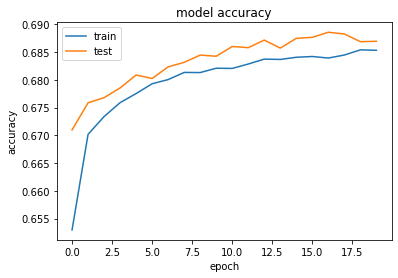

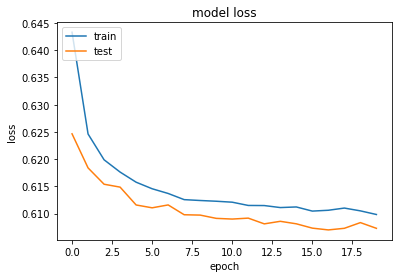

              precision    recall  f1-score   support

Not Realized       0.70      0.83      0.76     22654
    Realized       0.66      0.48      0.55     15495

    accuracy                           0.69     38149
   macro avg       0.68      0.65      0.66     38149
weighted avg       0.68      0.69      0.68     38149



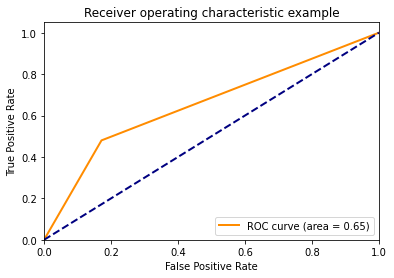

In [34]:
#assign the result to here
result = (history)

# list all data in history
print(result.history.keys())
# summarize history for accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# confusion matrix
y_pred = dnn_n.predict_classes(X_test)

target_names = ['Not Realized', 'Realized']
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
##### Evaluate accuracy with different thresholds

## Data processing
Predicted_Probi = dnn_n.predict(X_test)
Predicted_class = dnn_n.predict_classes(X_test)
compared_result = pd.DataFrame({"Predicted_Probi": Predicted_Probi.reshape(len(y_test)), "Predicted_class": Predicted_class.reshape(len(y_test)), "Actual_class": y_test})

## > 0.9
compared_result_threshold = compared_result.assign(Prediction = abs(compared_result.Predicted_class - compared_result.Actual_class))[compared_result.Predicted_Probi > 0.9].groupby("Prediction").count()
realized_opp = compared_result_threshold.get("Predicted_Probi")[0]
total_opp_with_threshold = (compared_result_threshold.get("Predicted_Probi")[0] + compared_result_threshold.get("Predicted_Probi")[1])
realized_rate_with_threshold = realized_opp / total_opp_with_threshold
print("The number of opportunity with threshold greater than 0.9 is",total_opp_with_threshold ,"and the realized rate is", realized_rate_with_threshold)

## < 0.9 and > 0.8
compared_result_threshold = compared_result.assign(Prediction = abs(compared_result.Predicted_class - compared_result.Actual_class))[(compared_result.Predicted_Probi < 0.9) & (compared_result.Predicted_Probi > 0.8)].groupby("Prediction").count()
realized_opp = compared_result_threshold.get("Predicted_Probi")[0]
total_opp_with_threshold = (compared_result_threshold.get("Predicted_Probi")[0] + compared_result_threshold.get("Predicted_Probi")[1])
realized_rate_with_threshold = realized_opp / total_opp_with_threshold
print("The number of opportunity with threshold >0.8 and <0.9 is",total_opp_with_threshold ,"and the realized rate is", realized_rate_with_threshold)

## < 0.8 and > 0.7
compared_result_threshold = compared_result.assign(Prediction = abs(compared_result.Predicted_class - compared_result.Actual_class))[(compared_result.Predicted_Probi < 0.8) & (compared_result.Predicted_Probi > 0.7)].groupby("Prediction").count()
realized_opp = compared_result_threshold.get("Predicted_Probi")[0]
total_opp_with_threshold = (compared_result_threshold.get("Predicted_Probi")[0] + compared_result_threshold.get("Predicted_Probi")[1])
realized_rate_with_threshold = realized_opp / total_opp_with_threshold
print("The number of opportunity with threshold >0.7 and <0.8 is",total_opp_with_threshold ,"and the realized rate is", realized_rate_with_threshold)

## < 0.6 and > 0.5
compared_result_threshold = compared_result.assign(Prediction = abs(compared_result.Predicted_class - compared_result.Actual_class))[(compared_result.Predicted_Probi < 0.6) & (compared_result.Predicted_Probi > 0.5)].groupby("Prediction").count()
realized_opp = compared_result_threshold.get("Predicted_Probi")[0]
total_opp_with_threshold = (compared_result_threshold.get("Predicted_Probi")[0] + compared_result_threshold.get("Predicted_Probi")[1])
realized_rate_with_threshold = realized_opp / total_opp_with_threshold
print("The number of opportunity with threshold >0.6 and <0.7 is",total_opp_with_threshold ,"and the realized rate is", realized_rate_with_threshold)

The number of opportunity with threshold greater than 0.9 is 118 and the realized rate is 0.9322033898305084
The number of opportunity with threshold >0.8 and <0.9 is 703 and the realized rate is 0.829302987197724
The number of opportunity with threshold >0.7 and <0.8 is 2583 and the realized rate is 0.7611304684475416
The number of opportunity with threshold >0.6 and <0.7 is 3942 and the realized rate is 0.5461694571283613


**4.2 Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#create a naive bayes classifier
model_naive =GaussianNB()
model_naive.fit(X_train, y_train)
y_pred_naive_grade = model_naive.predict(X_test)

#calculate the accuracy
accuracy_score(y_test, y_pred_naive_grade)

0.6210909853469292

**4.3 decision tree model**

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=40,min_samples_leaf=100)
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
y_pred_tree_prob = clf.predict_proba(X_test)

y_pred_tree_prob.shape
#calculate the accuracy
accuracy_score(y_test, y_pred_tree)

0.6847885920993997

**4.4 logistic regression model**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict_proba(X_test) 
y_pred_logistic = clf.predict(X_test)

#calculate the accuracy
accuracy_score(y_test, y_pred_logistic)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6597289575087159